In [1]:
"""
Bloco 0 — Configuração geral
- Importa bibliotecas usadas no notebook inteiro
- Define semente, tema e paleta fixa por cluster
- Define N_AMOSTRA (apenas para VISUALIZAÇÕES: pairplot e barras)
- Funções auxiliares para salvar CSV (pt-BR) e Excel (engine padrão do pandas)
"""

# -----------------------------
# Imports
# -----------------------------
import os
import re
import unicodedata
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway, kruskal, chi2_contingency

# -----------------------------
# Pastas de saída
# -----------------------------
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# -----------------------------
# Reprodutibilidade + tema
# -----------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid", context="notebook")

# Paleta fixa por cluster (mantém cores consistentes ao longo do notebook)
PALETA_BASE    = sns.color_palette("deep", 3)
CLUSTER_ORDEM  = [0, 1, 2]
CLUSTER_PALETA = {0: PALETA_BASE[0], 1: PALETA_BASE[1], 2: PALETA_BASE[2]}

# -----------------------------
# N_AMOSTRA (apenas para gráficos)
# -----------------------------
# Usado para limitar o número de pontos nos gráficos (p.ex., pairplot),
# melhorando legibilidade e performance. NÃO afeta clusterização, testes
# estatísticos ou quaisquer cálculos — apenas as figuras.
# → Para desativar a amostragem nos gráficos, defina N_AMOSTRA = None.
N_AMOSTRA: int | None = 5000

# -----------------------------
# Helpers de saída
# -----------------------------
def salvar_csv_ptbr(df: pd.DataFrame, caminho: str) -> None:
    """Salva DataFrame em CSV com separador ';' e vírgula decimal (pt-BR)."""
    df.to_csv(caminho, sep=";", decimal=",", index=False, encoding="utf-8-sig")

def salvar_excel(df: pd.DataFrame, caminho: str, nome_aba: str = "Planilha") -> None:
    """
    Salva DataFrame em XLSX usando o engine padrão do pandas (ex.: openpyxl).
    Sem dependências extras e sem auto-largura de colunas.
    """
    df.to_excel(caminho, sheet_name=nome_aba, index=False)


In [2]:
"""
Bloco 1 — Carga dos dados (CSV/XLSX) + filtro via Aérea + variáveis base
- Lê CSV pt-BR (sep=';', decimal=',') ou padrão, ou Excel (aba opcional).
- Filtra somente entrevistados com via de saída AÉREA (quando a coluna existir).
- Cria variáveis numéricas base: logGasto, logPernoite.
- Padroniza 'primeira_vez' como 0 (repetente) / 1 (primeira visita) com fallback.
Pré-requisitos: imports no Bloco 0
"""

# ===== 1) Configuração do arquivo =====
CAMINHO_ARQUIVO = r"Receptivo 2019.xlsx"   # ex.: r"C:\...\Receptivo 2019.xlsx" ou "dados.csv"
NOME_ABA = None  # se souber a aba, ex.: "Bd2019"; se None, pega a 1ª

# ===== 2) Leitura do arquivo =====
def _ler_excel(caminho: str, sheet=None) -> pd.DataFrame:
    """Lê Excel; se a aba não for informada, usa a primeira e acusa se inexistente."""
    xls = pd.ExcelFile(caminho)
    if sheet is None:
        sheet = xls.sheet_names[0]
    elif sheet not in xls.sheet_names:
        raise ValueError(f"Aba '{sheet}' não encontrada. Abas disponíveis: {xls.sheet_names}")
    return pd.read_excel(xls, sheet_name=sheet)

def _ler_csv(caminho: str) -> pd.DataFrame:
    """Tenta CSV pt-BR (sep=';', decimal=','); se falhar, tenta CSV padrão (',', '.')."""
    try:
        return pd.read_csv(caminho, sep=";", decimal=",", encoding="utf-8")
    except Exception:
        return pd.read_csv(caminho, encoding="utf-8")

p = Path(CAMINHO_ARQUIVO)
if not p.exists():
    existentes = sorted(q.name for q in Path(".").glob("*"))
    raise FileNotFoundError(
        f"Arquivo não encontrado: {p}\n"
        f"Pasta atual: {Path('.').resolve()}\n"
        f"Arquivos visíveis: {existentes}\n"
        f"→ Ajuste CAMINHO_ARQUIVO."
    )

if p.suffix.lower() in {".xlsx", ".xls"}:
    df = _ler_excel(str(p), NOME_ABA)
else:
    df = _ler_csv(str(p))

# ===== 3) Filtro via Aérea (quando existir coluna de via/fronteira) =====
def _sem_acento(txt: str) -> str:
    """Remove acentos para facilitar o match robusto."""
    s = str(txt)
    s = "".join(ch for ch in unicodedata.normalize("NFKD", s) if unicodedata.category(ch) != "Mn")
    return s

def _filtrar_via_aerea(base: pd.DataFrame) -> pd.DataFrame:
    candidatos = ["Fronteira", "via", "viaSaida", "via_saida", "meioTransporteSaida", "meioTransporte_Saida"]
    cols = [c for c in candidatos if c in base.columns]
    if not cols:
        return base
    col = cols[0]
    s = base[col].astype(str).apply(_sem_acento).str.lower()
    # Matches robustos para "aérea/aereo", mantendo simples
    mask = s.str.contains(r"\baerea\b|\baereo\b|aerea|aereo|aer")
    return base.loc[mask].copy()

df = _filtrar_via_aerea(df)

# ===== 4) Variáveis numéricas base (log1p) =====
def _to_num(x):
    return pd.to_numeric(x, errors="coerce")

col_gasto    = "valGastoBrasil"
col_pernoite = "numPernoiteTotal"

faltando = [c for c in (col_gasto, col_pernoite) if c not in df.columns]
if faltando:
    raise ValueError(f"Colunas não encontradas: {faltando}. Confirme os nomes no arquivo.")

df[col_gasto]     = _to_num(df[col_gasto])
df[col_pernoite]  = _to_num(df[col_pernoite])
df["logGasto"]    = np.log1p(df[col_gasto])
df["logPernoite"] = np.log1p(df[col_pernoite])

# ===== 5) Primeira visita (0 = repetente, 1 = primeira) =====
def _primeira_vez_row(row) -> float:
    # regra 1: numVezes >= 1 => repetente (0)
    if "numVezes" in row and pd.notna(row["numVezes"]):
        try:
            if float(row["numVezes"]) >= 1:
                return 0.0
        except Exception:
            pass
    # regra 2: fallback em codPrimeiraVisita textual
    if "codPrimeiraVisita" in row and pd.notna(row["codPrimeiraVisita"]):
        s = str(row["codPrimeiraVisita"]).strip().lower()
        if s in {"sim", "s", "1", "true"}:
            return 1.0
        if s in {"nao", "não", "n", "0", "false"}:
            return 0.0
    return np.nan

df["primeira_vez"] = df.apply(_primeira_vez_row, axis=1) if (
    "numVezes" in df.columns or "codPrimeiraVisita" in df.columns
) else np.nan

# ===== 6) Checagem rápida =====
print("Dimensão após via Aérea:", df.shape)
print(df[[col_gasto, col_pernoite, "logGasto", "logPernoite", "primeira_vez"]].head(8))
print("\nProporção de ausentes:", df[["logGasto", "logPernoite", "primeira_vez"]].isna().mean().round(3).to_dict())


Dimensão após via Aérea: (34642, 259)
   valGastoBrasil  numPernoiteTotal  logGasto  logPernoite  primeira_vez
0            1750                20  7.467942     3.044522           0.0
1             110                 3  4.709530     1.386294           0.0
4            1550                14  7.346655     2.708050           1.0
5              17                 1  2.890372     0.693147           0.0
6             771                11  6.648985     2.484907           0.0
7             525                 8  6.265301     2.197225           1.0
8              80                 7  4.394449     2.079442           0.0
9             534                10  6.282267     2.397895           0.0

Proporção de ausentes: {'logGasto': 0.0, 'logPernoite': 0.0, 'primeira_vez': 0.007}


In [3]:
# =========================================
# Bloco 2 — Idade (coluna única: `idade_mediana`)
# - Mantém uma única coluna numérica `idade_mediana` para o pipeline.
# - Regras:
#   • Se já existir `idade_mediana` numérica plausível (10–100), preserva.
#   • Onde faltar/for inválida, deriva de `faixaIdade`:
#       "X a Y anos"  -> (X+Y)/2
#       "Acima de 60" -> 65.0 (convenção para classe aberta)
#   • Fora de [10, 100] -> NaN
# =========================================

def _normalizar_txt(s):
    """Normaliza texto para comparação: maiúsculas, sem acentos, espaços simples."""
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    s = re.sub(r"\s+", " ", s).strip().upper()
    return s

def _mediana_da_faixa(txt):
    """
    Converte descrições de faixa etária em um ponto de mediana.
    Exemplos:
      - "18 a 24 anos" -> 21.0
      - "32 a 40 anos" -> 36.0
      - "Acima de 60 anos" -> 65.0
    Retorna float ou np.nan.
    """
    if not isinstance(txt, str):
        return np.nan
    t = _normalizar_txt(txt)

    # padrão "X a Y"
    m = re.search(r"(\d+)\s*A\s*(\d+)", t)
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        med = (a + b) / 2.0
        return med if 10 <= med <= 100 else np.nan

    # "ACIMA DE 60" (ou similares)
    if "ACIMA" in t and re.search(r"\b6\d\b|\b60\b", t):
        return 65.0  # convenção para classe aberta

    return np.nan

# 2.1) Tenta usar `idade_mediana` existente, coerindo para numérico e validando faixa
if "idade_mediana" in df.columns:
    idade_num = pd.to_numeric(df["idade_mediana"], errors="coerce")
    idade_num = idade_num.where(idade_num.between(10, 100), np.nan)
else:
    idade_num = pd.Series(np.nan, index=df.index)

# 2.2) Onde faltou/está inválida, deriva de `faixaIdade` (se existir)
if "faixaIdade" in df.columns:
    idade_derivada = df["faixaIdade"].apply(_mediana_da_faixa)
    idade_final = idade_num.fillna(idade_derivada)
else:
    idade_final = idade_num.copy()

# 2.3) Limpeza final de plausibilidade e gravação
idade_final = idade_final.where(idade_final.between(10, 100), np.nan)
df["idade_mediana"] = idade_final.astype("float64")

# 2.4) Checagem rápida (sem poluir)
print("Proporção de ausentes em idade_mediana:", df["idade_mediana"].isna().mean().round(3))
print("Exemplo (faixaIdade → idade_mediana):")
display(df[["faixaIdade", "idade_mediana"]].head(8))


Proporção de ausentes em idade_mediana: 0.0
Exemplo (faixaIdade → idade_mediana):


,faixaIdade,idade_mediana
0,32 a 40 anos,36.0
1,25 a 31 anos,28.0
4,32 a 40 anos,36.0
5,18 a 24 anos,21.0
6,Acima de 60 anos,65.0
7,25 a 31 anos,28.0
8,51 a 59 anos,55.0
9,32 a 40 anos,36.0


,k,inercia,silhueta
0,2,158296.609847,0.175533
1,3,141087.261849,0.147922
2,4,129506.691382,0.143707
3,5,121104.287116,0.133075
4,6,114954.850974,0.127638
5,7,109717.239290,0.127313
6,8,105054.095968,0.131389


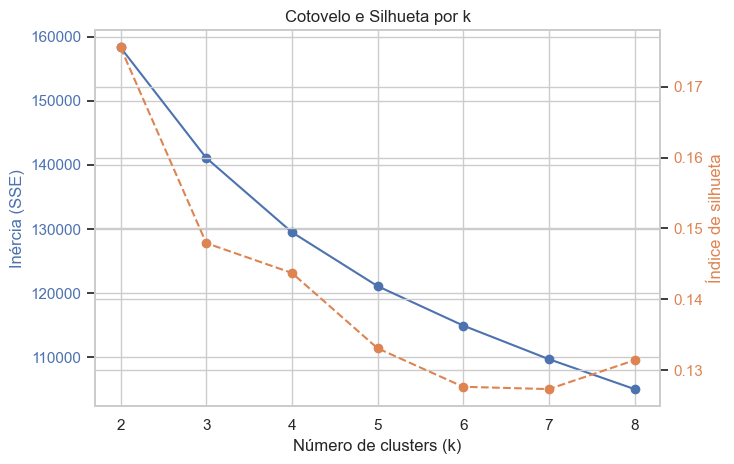

{'pico_silhueta': 2, 'cotovelo': 8}
X shape: (34641, 39) | linhas no modelo: 34,641


In [4]:
# =========================================
# Bloco 3 — Matriz de modelagem + escolha de k
# - Constrói X (numéricas padronizadas + categóricas one-hot)
# - Trata 'primeira_vez' como categórica (rótulos)
# - (Se necessário) deriva 'continente' a partir de 'nomPais'
# - Avalia k de 2 a 8 por inércia e índice de silhueta
# - Gera gráfico combinado: cotovelo + silhueta (uma figura)
# =========================================

# 3.1) Continente (apenas se ainda não existir)
def _norm_txt(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return re.sub(r"\s+", " ", s).strip().upper()

if "continente" not in df.columns:
    AM_SUL = {
        "ARGENTINA","URUGUAI","PARAGUAI","CHILE","BOLIVIA","PERU","COLOMBIA",
        "VENEZUELA","EQUADOR","GUIANA","SURINAME","GUIANA FRANCESA"
    }
    AM_NORTE = {"ESTADOS UNIDOS","EUA","UNITED STATES","CANADA","MEXICO"}
    AM_CENTRO_CARIBE = {
        "CUBA","REPUBLICA DOMINICANA","JAMAICA","BAHAMAS","BARBADOS","TRINIDAD E TOBAGO",
        "ARUBA","CURACAO","SAINT MARTIN","ANTIGUA E BARBUDA","SAINT LUCIA","GRENADA",
        "BELIZE","HONDURAS","GUATEMALA","NICARAGUA","COSTA RICA","PANAMA","EL SALVADOR",
        "HAITI","PORTO RICO","PUERTO RICO"
    }
    EUROPA = {
        "PORTUGAL","ESPANHA","ITALIA","FRANCA","FRANÇA","ALEMANHA","REINO UNIDO","INGLATERRA",
        "ESCOCIA","ESCÓCIA","IRLANDA","PAISES BAIXOS","HOLANDA","BELGICA","BÉLGICA","SUECIA",
        "SUÉCIA","NORUEGA","DINAMARCA","FINLANDIA","FINLÂNDIA","SUIÇA","SUICA","AUSTRIA",
        "POLONIA","HUNGRIA","GRECIA","TURQUIA","RUSSIA","REPUBLICA TCHECA","TCHÉCA",
        "CROACIA","ROMENIA","BULGARIA","UCRANIA","SERVIA","ESLOVENIA","ESLOVAQUIA","ISLANDIA",
        "MALTA","ESTONIA","LETONIA","LITUANIA","LUXEMBURGO","MONACO","ANDORRA","SAN MARINO",
        "BOSNIA E HERZEGOVINA","MACEDONIA DO NORTE","MOLDAVIA","MONTENEGRO","BELARUS"
    }
    ASIA = {
        "CHINA","JAPAO","JAPÃO","COREIA DO SUL","COREIA","INDIA","ÍNDIA","INDONESIA","MALASIA",
        "SINGAPURA","CINGAPURA","TAILANDIA","VIETNA","FILIPINAS","EMIRADOS ARABES UNIDOS",
        "ISRAEL","QATAR","ARABIA SAUDITA","JORDANIA","LIBANO","PALESTINA","TAIWAN","HONG KONG"
    }
    AFRICA = {
        "AFRICA DO SUL","ÁFRICA DO SUL","MARROCOS","EGITO","ANGOLA","MOÇAMBIQUE","CABO VERDE",
        "TUNISIA","QUENIA","TANZANIA","NIGERIA","ETIOPIA","GANA","NAMIBIA","ZIMBABUE","ALGERIA",
        "CAMAROES","SENEGAL"
    }
    OCEANIA = {"AUSTRALIA","NOVA ZELANDIA","FIJI","AUSTRÁLIA","NOVA ZELÂNDIA"}

    def pais_para_continente(pais) -> str:
        p = _norm_txt(pais)
        if p in AM_SUL: return "América do Sul"
        if p in AM_NORTE: return "América do Norte"
        if p in AM_CENTRO_CARIBE: return "América Central e Caribe"
        if p in EUROPA: return "Europa"
        if p in ASIA: return "Ásia"
        if p in AFRICA: return "África"
        if p in OCEANIA: return "Oceania"
        return "Outro/Indefinido"

    if "nomPais" in df.columns:
        df["continente"] = df["nomPais"].apply(pais_para_continente)
    else:
        df["continente"] = "Outro/Indefinido"  # fallback neutro

# 3.2) Primeira_vez como categórica (rótulos para one-hot)
def _rotulo_primeira(x):
    if pd.isna(x): return np.nan
    return "Primeira vez" if float(x) == 1.0 else "Repetente"

df["primeira_vez_cat"] = df["primeira_vez"].apply(_rotulo_primeira)

# 3.3) Define colunas do modelo
col_num = ["logGasto", "logPernoite", "idade_mediana"]
col_cat = [c for c in ["continente","nomMotivo","nomHospedagem","primeira_vez_cat"] if c in df.columns]

# Remove linhas com ausências nas numéricas (categóricas serão imputadas)
df_modelo = df.dropna(subset=col_num).copy()

# 3.4) Pipelines
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

pre = ColumnTransformer([
    ("num", num_pipe, col_num),
    ("cat", cat_pipe, col_cat)
])

# 3.5) Matriz X
X = pre.fit_transform(df_modelo)

# 3.6) Varredura de k e métricas
ks = list(range(2, 8 + 1))
inercia, silhueta = [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    rotulos = km.fit_predict(X)
    inercia.append(km.inertia_)
    try:
        silhueta.append(silhouette_score(X, rotulos))
    except Exception:
        silhueta.append(np.nan)

res_k = pd.DataFrame({"k": ks, "inercia": inercia, "silhueta": silhueta})
display(res_k)

# 3.7) Gráfico combinado (cotovelo + silhueta) em uma figura
fig, ax1 = plt.subplots(figsize=(7.5, 4.8))
ax1.plot(ks, inercia, marker="o")
ax1.set_xlabel("Número de clusters (k)")
ax1.set_ylabel("Inércia (SSE)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")

ax2 = ax1.twinx()
ax2.plot(ks, silhueta, marker="o", linestyle="--", color="C1")
ax2.set_ylabel("Índice de silhueta", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

plt.title("Cotovelo e Silhueta por k")
fig.tight_layout()
plt.savefig("figures/cotovelo_silhueta.png", dpi=150)
plt.show()

# 3.8) Sugestões auxiliares
k_pico_sil = int(res_k.loc[res_k["silhueta"].idxmax(), "k"])
drops = np.diff(inercia)
k_cotovelo = int(ks[np.argmax(drops) + 1])
print({"pico_silhueta": k_pico_sil, "cotovelo": k_cotovelo})
print(f"X shape: {X.shape} | linhas no modelo: {len(df_modelo):,}")


In [5]:
# =========================================
# Bloco 4 — Treino final (k=3), rótulos estáveis e amostra p/ gráficos
# - Ajusta KMeans com k=3 na matriz X (do Bloco 3)
# - Garante rótulos estáveis: ordena clusters por mediana de logPernoite
#   (e em caso de empate, por mediana de logGasto), e remapeia para {0,1,2}
# - Anexa 'cluster_k3' ao df_modelo e ao df original (NaN fora do conjunto de modelagem)
# - Cria 'amostra' estratificada por cluster para plots
# - Exporta contagens/percentuais por cluster (opcional)
# =========================================

K_FINAL = 3

# 4.1) Ajusta o KMeans no X (matriz do Bloco 3)
kmeans = KMeans(n_clusters=K_FINAL, random_state=RANDOM_STATE, n_init=10)
rotulos_raw = kmeans.fit_predict(X)

# 4.2) Rótulos estáveis por ordenação (evita "troca" de clusters entre execuções)
tmp_lab = pd.Series(rotulos_raw, index=df_modelo.index, name="label_raw")

# juntamos rótulo bruto ao df_modelo para calcular medianas por cluster
tmp_df = df_modelo[["logPernoite", "logGasto"]].copy()
tmp_df["label_raw"] = tmp_lab

ordem = (
    tmp_df.groupby("label_raw", observed=True)
          .median(numeric_only=True)
          .sort_values(by=["logPernoite", "logGasto"], ascending=[True, True])
          .index.tolist()
)
# exemplo: se 'ordem' == [2, 0, 1], então 2->0, 0->1, 1->2
map_old2new = {old: new for new, old in enumerate(ordem)}

rotulos_estaveis = tmp_lab.map(map_old2new)

# 4.3) Anexa ao df_modelo e ao df original
df_modelo["cluster_k3"] = rotulos_estaveis
df["cluster_k3"] = np.nan
df.loc[df_modelo.index, "cluster_k3"] = rotulos_estaveis

# 4.4) Ajusta uma amostra estratificada para gráficos (até 5000 obs)
n_por_cluster = (
    df_modelo["cluster_k3"].value_counts().sort_index().to_dict()
)
n_total = len(df_modelo)
quota = max(1, int(5000 / K_FINAL))

amostras = []
for k in range(K_FINAL):
    parte = df_modelo[df_modelo["cluster_k3"] == k].sample(
        n=min(quota, n_por_cluster.get(k, 0)),
        random_state=RANDOM_STATE
    )
    amostras.append(parte)

amostra = pd.concat(amostras, axis=0).copy()

# 4.5) Resumo rápido (contagens e %)
cont = df_modelo["cluster_k3"].value_counts().sort_index()
pct  = (cont / cont.sum() * 100).round(1)
resumo_clusters = pd.DataFrame({"n": cont, "%": pct})
display(resumo_clusters)

# 4.6) (Opcional) Exporta resumo
salvar_csv_ptbr(resumo_clusters.reset_index().rename(columns={"index":"cluster"}),
                "tables/Resumo_clusters_k3.csv")

print(
    f"Rotulagem concluída. X: {X.shape} | "
    f"map_old2new (estabilização): {map_old2new} | "
    f"amostra para plots: {amostra.shape}"
)


,n,%
cluster_k3,,
0,12851,37.1
1,11177,32.3
2,10613,30.6


Rotulagem concluída. X: (34641, 39) | map_old2new (estabilização): {2: 0, 0: 1, 1: 2} | amostra para plots: (4998, 263)


In [6]:
"""
Bloco 5 — Tabela 1 (resumo dos clusters, transposta)
- Para cada cluster (linhas originais): médias/medianas de gasto e pernoites, mediana de idade,
  e a categoria modal de motivo e hospedagem com sua proporção.
- A saída final é TRANSPOSTA (clusters em colunas), no formato do artigo.
- Exporta CSV (pt-BR) e XLSX.
"""

# ----------------------------
# 5.1) Helpers
# ----------------------------
def _top_e_prop(serie: pd.Series) -> pd.Series:
    """
    Retorna a categoria modal ('categoria') e sua proporção ('proporcao')
    dentro de uma série categórica.
    """
    s = serie.fillna("Não informado")
    vc = s.value_counts(dropna=False)
    if vc.empty:
        return pd.Series({"categoria": np.nan, "proporcao": np.nan})
    categoria = vc.idxmax()
    proporcao = vc.max() / vc.sum()
    return pd.Series({"categoria": categoria, "proporcao": proporcao})

# ----------------------------
# 5.2) Agregações por cluster
# ----------------------------
grp = df_modelo.groupby("cluster_k3", sort=True)

# moda e proporção (como DataFrame com colunas 'categoria' e 'proporcao')
top_motivo = grp["nomMotivo"].apply(_top_e_prop).unstack()       # -> colunas: categoria, proporcao
top_hosp   = grp["nomHospedagem"].apply(_top_e_prop).unstack()   # -> colunas: categoria, proporcao

# quadro base (clusters em linhas)
t1 = pd.DataFrame({
    "Gasto total (US$) — média" : grp["valGastoBrasil"].mean(),
    "Gasto total (US$) — mediana": grp["valGastoBrasil"].median(),
    "Pernoites — média"          : grp["numPernoiteTotal"].mean(),
    "Pernoites — mediana"        : grp["numPernoiteTotal"].median(),
    "Idade — mediana"            : grp["idade_mediana"].median(),
    "Principal motivo"           : top_motivo["categoria"],
    "Proporção motivo"           : (top_motivo["proporcao"] * 100),
    "Principal hospedagem"       : top_hosp["categoria"],
    "Proporção hospedagem"       : (top_hosp["proporcao"] * 100),
})

# garante a ordem dos clusters (0–1–2) se definida
if "CLUSTER_ORDEM" in globals():
    t1 = t1.reindex(CLUSTER_ORDEM)

# ----------------------------
# 5.3) Formatação e transposição
# ----------------------------
# arredonda numéricos; percentuais em string com vírgula e '%'
t1_fmt = t1.copy()
t1_fmt[["Gasto total (US$) — média",
        "Pernoites — média"]] = t1_fmt[["Gasto total (US$) — média",
                                        "Pernoites — média"]].round(2)
t1_fmt[["Gasto total (US$) — mediana",
        "Pernoites — mediana",
        "Idade — mediana"]] = t1_fmt[["Gasto total (US$) — mediana",
                                      "Pernoites — mediana",
                                      "Idade — mediana"]].round(1)

for col_pct in ["Proporção motivo", "Proporção hospedagem"]:
    t1_fmt[col_pct] = t1_fmt[col_pct].round(1).map(lambda x: f"{x:.1f}%".replace(".", ","))

# renomeia colunas para “Cluster 0/1/2” ao transpor
t1_transp = t1_fmt.T
t1_transp.columns = [f"Cluster {c}" for c in t1_transp.columns]

# ----------------------------
# 5.4) Exporta e mostra
# ----------------------------
salvar_csv_ptbr(t1_transp.reset_index().rename(columns={"index": "Indicador"}),
                "tables/Tabela_1_resumo_clusters_transposta.csv")
salvar_excel(t1_transp.reset_index().rename(columns={"index": "Indicador"}),
             "tables/Tabela_1_resumo_clusters_transposta.xlsx",
             nome_aba="Tabela 1")

display(t1_transp)


,Cluster 0,Cluster 1,Cluster 2
Gasto total (US$) — média,803.32,1026.09,2386.37
Gasto total (US$) — mediana,578.0,682.0,1420.0
Pernoites — média,8.4,8.7,39.86
Pernoites — mediana,7.0,7.0,30.0
Idade — mediana,28.0,55.0,36.0
Principal motivo,Lazer,Lazer,Visita a amigos e parentes
Proporção motivo,"56,4%","46,3%","68,8%"
Principal hospedagem,1. Hotel ou flat,1. Hotel ou flat,4. Casa de amigos e parentes
Proporção hospedagem,"53,9%","60,0%","68,4%"


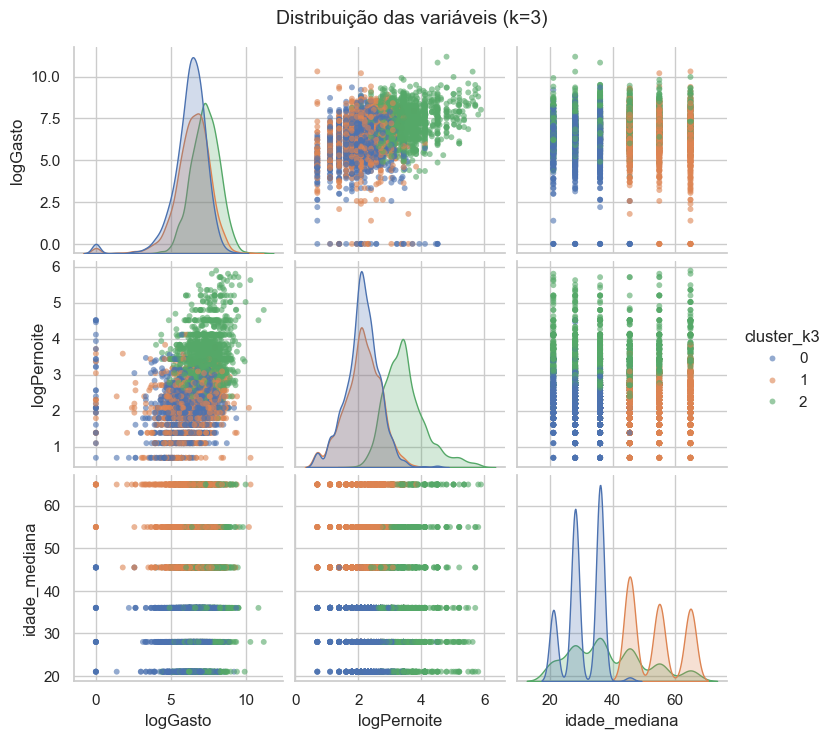

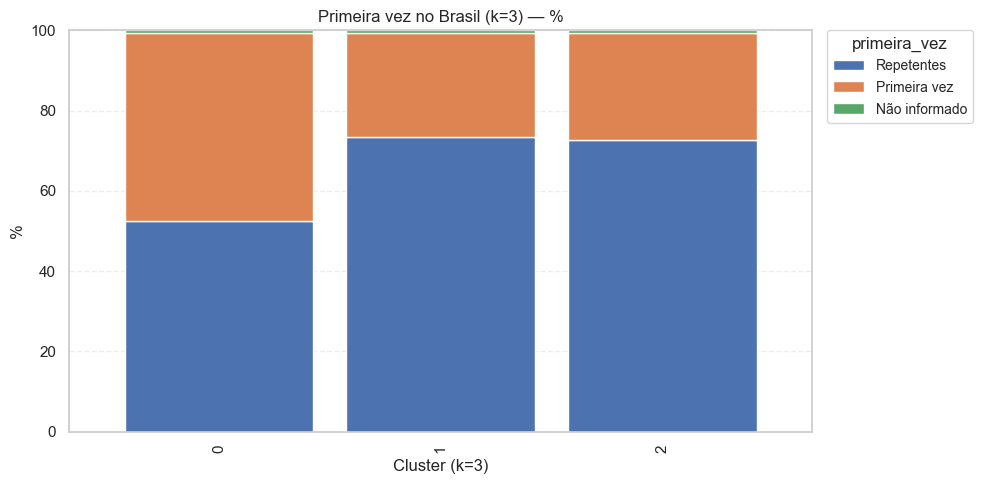

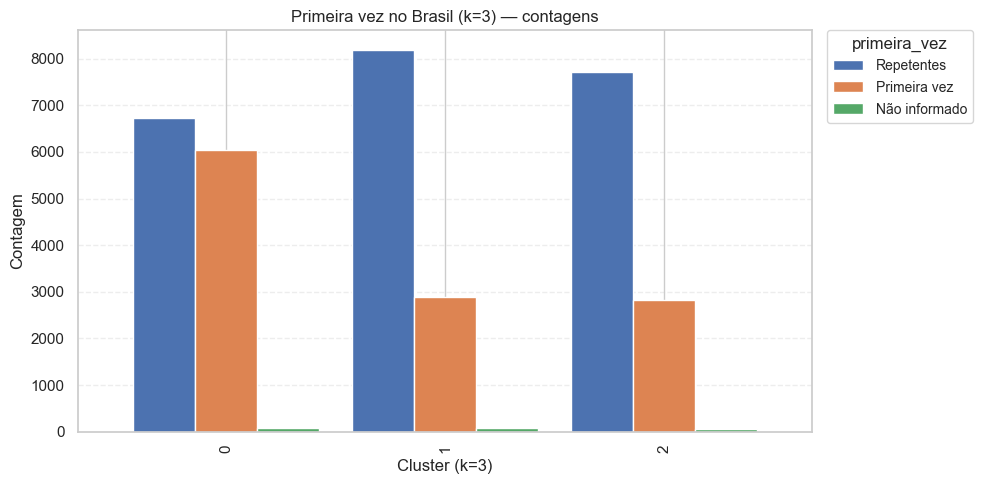

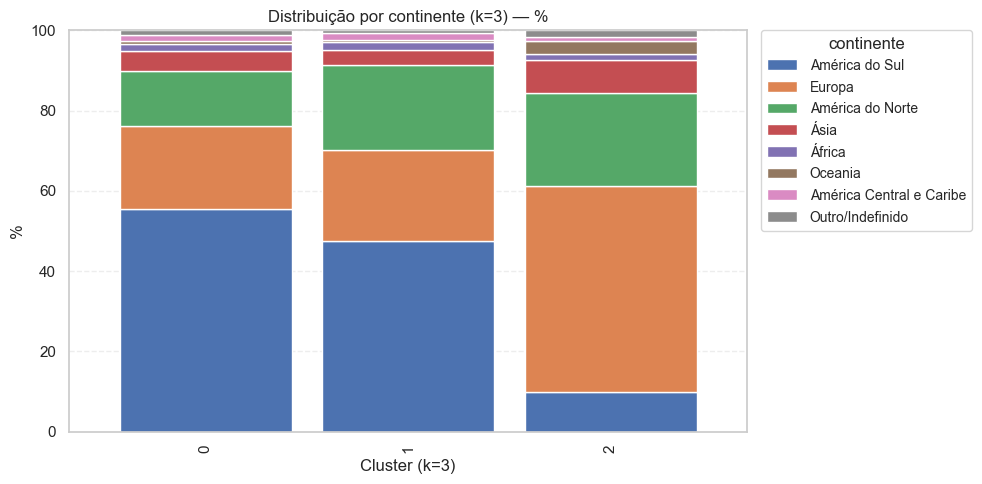

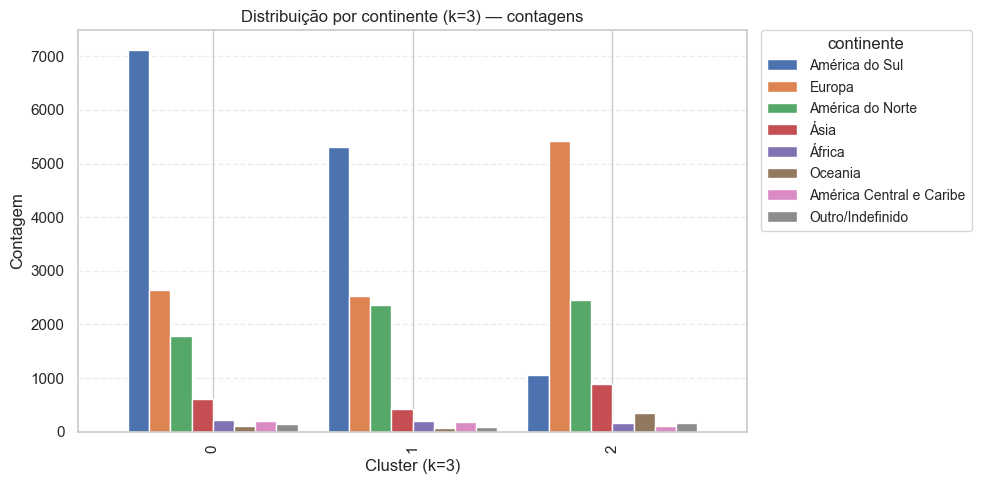

In [7]:
"""
Bloco 6 — Gráficos por cluster (k = 3)
- Pairplot (logGasto, logPernoite, idade_mediana) com amostragem controlada por N_AMOSTRA (Bloco 0)
- Barras empilhadas (%) e barras de contagem para 'primeira_vez' e 'continente'
Pré-requisitos: df_modelo com 'cluster_k3'; CLUSTER_ORDEM, CLUSTER_PALETA, RANDOM_STATE, N_AMOSTRA (Bloco 0).
"""

# ----------------------------
# 6.0) Checagem de pré-requisitos
# ----------------------------
if "df_modelo" not in globals() or df_modelo is None or df_modelo.empty:
    raise RuntimeError("df_modelo indisponível. Execute os blocos anteriores (modelo e rotulagem).")

# ----------------------------
# 6.1) Pairplot (matriz 3x3)
# ----------------------------
# - N_AMOSTRA é definido no Bloco 0. Se for None, usa o dataset completo nos gráficos.
if N_AMOSTRA is None:
    amostra = df_modelo.copy()
else:
    tam = min(int(N_AMOSTRA), len(df_modelo))
    amostra = df_modelo.sample(n=tam, random_state=RANDOM_STATE).copy()

amostra["cluster_k3"] = amostra["cluster_k3"].astype(int)
vars_pp = ["logGasto", "logPernoite", "idade_mediana"]

g = sns.pairplot(
    amostra,
    vars=vars_pp,
    hue="cluster_k3",
    hue_order=CLUSTER_ORDEM,
    palette=CLUSTER_PALETA,
    diag_kind="kde",
    corner=False,
    plot_kws={"alpha": 0.6, "s": 18, "edgecolor": "none"}
)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Distribuição das variáveis (k=3)", fontsize=14)
g.fig.savefig("figures/pairplot_k3.png", dpi=150)
plt.show()
plt.close(g.fig)

# -----------------------------------------------------
# 6.2) Helpers para barras (% empilhado) e contagem
# -----------------------------------------------------
def _alinhar_tabela(ct, ordem_cols=None, ordem_idx=None):
    """Garante a mesma ordem de linhas/colunas e insere categorias faltantes com zero."""
    if ordem_idx is not None:
        for i in ordem_idx:
            if i not in ct.index:
                ct.loc[i] = 0
        ct = ct.loc[[i for i in ordem_idx if i in ct.index]]
    if ordem_cols is not None:
        for c in ordem_cols:
            if c not in ct.columns:
                ct[c] = 0
        ct = ct[[c for c in ordem_cols if c in ct.columns]]
    return ct

def _plot_barras_empilhadas_percent(ct, titulo, caminho_png, ordem_cols=None, ordem_idx=None, legenda_titulo=None):
    ct = _alinhar_tabela(ct, ordem_cols, ordem_idx)
    pct = ct.div(ct.sum(axis=1), axis=0).mul(100)
    ax = pct.plot(kind="bar", stacked=True, figsize=(10, 5), width=0.85)
    ax.set_title(titulo)
    ax.set_xlabel("Cluster (k=3)")
    ax.set_ylabel("%")
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    leg = ax.legend(title=legenda_titulo, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    for t in leg.get_texts():
        t.set_fontsize(10)
    plt.tight_layout()
    plt.savefig(caminho_png, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

def _plot_barras_contagem(ct, titulo, caminho_png, ordem_cols=None, ordem_idx=None, legenda_titulo=None):
    ct = _alinhar_tabela(ct, ordem_cols, ordem_idx)
    ax = ct.plot(kind="bar", figsize=(10, 5), width=0.85)
    ax.set_title(titulo)
    ax.set_xlabel("Cluster (k=3)")
    ax.set_ylabel("Contagem")
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    leg = ax.legend(title=legenda_titulo, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    for t in leg.get_texts():
        t.set_fontsize(10)
    plt.tight_layout()
    plt.savefig(caminho_png, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

# ----------------------------------------------------------
# 6.3) Primeira_vez × cluster — % e contagem
# ----------------------------------------------------------
map_pv = {0: "Repetentes", 1: "Primeira vez"}
pv_series = df_modelo["primeira_vez"].map(map_pv).fillna("Não informado")
ct_pv = pd.crosstab(df_modelo["cluster_k3"].astype(int), pv_series)

# % empilhado
_plot_barras_empilhadas_percent(
    ct_pv,
    titulo="Primeira vez no Brasil (k=3) — %",
    caminho_png="figures/stack_primeiravez_k3.png",
    ordem_cols=["Repetentes", "Primeira vez", "Não informado"],
    ordem_idx=CLUSTER_ORDEM,
    legenda_titulo="primeira_vez"
)

# contagem
_plot_barras_contagem(
    ct_pv,
    titulo="Primeira vez no Brasil (k=3) — contagens",
    caminho_png="figures/primeiravez_agrupado_k3.png",
    ordem_cols=["Repetentes", "Primeira vez", "Não informado"],
    ordem_idx=CLUSTER_ORDEM,
    legenda_titulo="primeira_vez"
)

# ----------------------------------------------------------
# 6.4) Continente × cluster — % e contagem
# ----------------------------------------------------------
ordem_continentes = [
    "América do Sul", "Europa", "América do Norte", "Ásia",
    "África", "Oceania", "América Central e Caribe", "Outro/Indefinido"
]
ct_cont = pd.crosstab(df_modelo["cluster_k3"].astype(int), df_modelo["continente"])

# % empilhado
_plot_barras_empilhadas_percent(
    ct_cont,
    titulo="Distribuição por continente (k=3) — %",
    caminho_png="figures/stack_continente_k3.png",
    ordem_cols=ordem_continentes,
    ordem_idx=CLUSTER_ORDEM,
    legenda_titulo="continente"
)

# contagem
_plot_barras_contagem(
    ct_cont,
    titulo="Distribuição por continente (k=3) — contagens",
    caminho_png="figures/cont_agrupado_k3.png",
    ordem_cols=ordem_continentes,
    ordem_idx=CLUSTER_ORDEM,
    legenda_titulo="continente"
)


In [8]:
"""
Bloco 7 — Testes entre clusters (Tabela 5) + diagnóstico Qui²
Objetivo:
  - Variáveis numéricas: ANOVA (F, p, η²) e Kruskal–Wallis (H, p, ε²)
  - Variáveis categóricas: Qui² (p) + V de Cramér corrigido (medida de efeito)
  - Diagnóstico para Qui²: menor frequência esperada e % de células com esperado < 5
Saídas:
  - Exibe DataFrames no notebook
  - Exporta CSV (pt-BR, ';' e vírgula decimal) e XLSX em 'tables/'
Pré-requisitos:
  - df_modelo com colunas: cluster_k3, logGasto, logPernoite, idade_mediana,
    primeira_vez (0/1), continente, nomMotivo, nomHospedagem
  - Funções salvar_csv_ptbr e salvar_excel já definidas no Bloco 0
"""

# -----------------------
# 7.1) Utilitários locais
# -----------------------
def _fmt_p(p: float) -> str:
    """Formata p-valor: '<0,001' se muito pequeno; caso contrário 3 casas e vírgula decimal."""
    return "<0,001" if p < 0.001 else str(f"{p:.3f}").replace(".", ",")

def _fmt_dec(x: float, nd: int = 2) -> str:
    """Formata decimal com vírgula."""
    return str(f"{x:.{nd}f}").replace(".", ",")

def _cramers_v_corr(ct: pd.DataFrame, chi2: float) -> float:
    """
    V de Cramér com correção de viés (Bergsma, 2013).
    """
    n = ct.values.sum()
    r, c = ct.shape
    if n == 0 or r < 2 or c < 2:
        return np.nan
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((r - 1) * (c - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    ccorr = c - ((c - 1) ** 2) / (n - 1)
    denom = max(1.0, min(rcorr - 1, ccorr - 1))
    return float(np.sqrt(phi2corr / denom))

# -------------------------------
# 7.2) Configuração das variáveis
# -------------------------------
vars_numericas = ["logGasto", "logPernoite", "idade_mediana"]
vars_categoricas = ["primeira_vez", "continente", "nomMotivo", "nomHospedagem"]

clusters = sorted(df_modelo["cluster_k3"].dropna().astype(int).unique().tolist())

# -------------------------------
# 7.3) Numéricas: ANOVA e Kruskal
# -------------------------------
linhas = []

for v in vars_numericas:
    grupos = [
        df_modelo.loc[df_modelo["cluster_k3"] == k, v].astype(float).dropna().values
        for k in clusters
    ]
    # Proteção caso algum grupo esteja vazio
    if any(len(g) == 0 for g in grupos):
        continue

    # ANOVA
    F, pF = f_oneway(*grupos)
    n_total = sum(len(g) for g in grupos)
    k = len(grupos)
    df_between = k - 1
    df_within = n_total - k
    eta2 = (F * df_between) / (F * df_between + df_within)  # η² (ANOVA)

    linhas.append({
        "variavel": v,
        "teste": "ANOVA",
        "estatistica_ou_V": _fmt_dec(F, 2),
        "pvalor": _fmt_p(pF),
        "medida_efeito": "η²",
        "valor_efeito": _fmt_dec(max(0.0, min(1.0, eta2)), 3)
    })

    # Kruskal–Wallis
    H, pH = kruskal(*grupos)
    eps2 = (H - k + 1) / (n_total - k)  # ε² (Kruskal)
    linhas.append({
        "variavel": v,
        "teste": "Kruskal",
        "estatistica_ou_V": _fmt_dec(H, 2),
        "pvalor": _fmt_p(pH),
        "medida_efeito": "ε²",
        "valor_efeito": _fmt_dec(max(0.0, min(1.0, eps2)), 3)
    })

# -------------------------------------------------------
# 7.4) Categóricas: Qui² (p) + V de Cramér (medida efeito)
#       + diagnóstico (mínimo esperado e % esperado < 5)
# -------------------------------------------------------
diag_rows = []
map_pv = {0: "Repetentes", 1: "Primeira vez"}

for v in vars_categoricas:
    if v == "primeira_vez":
        serie = df_modelo["primeira_vez"].map(map_pv).fillna("Não informado")
    else:
        serie = df_modelo[v].astype("object").fillna("Não informado")

    ct = pd.crosstab(df_modelo["cluster_k3"].astype(int), serie)
    # remove linhas/colunas de total zero, se houver
    ct = ct.loc[(ct.sum(axis=1) > 0), (ct.sum(axis=0) > 0)]

    if ct.size == 0:
        continue

    chi2, p, dof, expected = chi2_contingency(ct, correction=False)
    V = _cramers_v_corr(ct, chi2)

    # linha principal (Tabela 5)
    linhas.append({
        "variavel": v,
        "teste": "Qui2_CramersV",
        "estatistica_ou_V": _fmt_dec(V, 2) if np.isfinite(V) else "",
        "pvalor": _fmt_p(p),
        "medida_efeito": "V",
        "valor_efeito": _fmt_dec(V, 3) if np.isfinite(V) else ""
    })

    # diagnóstico (mínimo esperado e % de células < 5)
    exp = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
    min_esp = float(exp.values.min()) if exp.size else np.nan
    pct_lt5 = float((exp.values < 5).sum() / exp.size * 100) if exp.size else np.nan

    diag_rows.append({
        "variavel": v,
        "min_esperado": round(min_esp, 2) if np.isfinite(min_esp) else np.nan,
        "pct_celulas_<5": round(pct_lt5, 1) if np.isfinite(pct_lt5) else np.nan
    })

# --------------------------
# 7.5) Monta e exporta saídas
# --------------------------
# Tabela 5 (ordena: numéricas ANOVA/Kruskal; depois categóricas Qui²)
ord_var = vars_numericas + vars_categoricas
ord_teste = {"ANOVA": 0, "Kruskal": 1, "Qui2_CramersV": 2}

tabela5 = pd.DataFrame(linhas,
                       columns=["variavel","teste","estatistica_ou_V","pvalor",
                                "medida_efeito","valor_efeito"]).copy()
tabela5["__ord_var"] = tabela5["variavel"].apply(lambda x: ord_var.index(x))
tabela5["__ord_teste"] = tabela5["teste"].map(ord_teste)
tabela5.sort_values(["__ord_var","__ord_teste"], inplace=True)
tabela5.drop(columns=["__ord_var","__ord_teste"], inplace=True)

# Diagnóstico Qui²
diag_qui2 = pd.DataFrame(diag_rows, columns=["variavel","min_esperado","pct_celulas_<5"])

# Exibe
display(tabela5)
display(diag_qui2)

# Exporta (CSV pt-BR + XLSX)
salvar_csv_ptbr(tabela5, "tables/Tabela_5_testes_formatada.csv")
salvar_excel(tabela5, "tables/Tabela_5_testes_formatada.xlsx", nome_aba="Tabela 5")

salvar_csv_ptbr(diag_qui2, "tables/Tabela_5_diagnostico_qui2.csv")
salvar_excel(diag_qui2, "tables/Tabela_5_diagnostico_qui2.xlsx", nome_aba="Diagnóstico Qui2")


,variavel,teste,estatistica_ou_V,pvalor,medida_efeito,valor_efeito
0,logGasto,ANOVA,"2765,40","<0,001",η²,"0,138"
1,logGasto,Kruskal,"5512,29","<0,001",ε²,"0,159"
2,logPernoite,ANOVA,"19698,75","<0,001",η²,"0,532"
3,logPernoite,Kruskal,"18705,06","<0,001",ε²,"0,540"
4,idade_mediana,ANOVA,"20803,04","<0,001",η²,"0,546"
5,idade_mediana,Kruskal,"19307,71","<0,001",ε²,"0,557"
6,primeira_vez,Qui2_CramersV,"0,15","<0,001",V,"0,149"
7,continente,Qui2_CramersV,"0,30","<0,001",V,"0,304"
8,nomMotivo,Qui2_CramersV,"0,40","<0,001",V,"0,402"
9,nomHospedagem,Qui2_CramersV,"0,42","<0,001",V,"0,423"


,variavel,min_esperado,pct_celulas_<5
0,primeira_vez,71.69,0.0
1,continente,119.18,0.0
2,nomMotivo,6.13,0.0
3,nomHospedagem,38.91,0.0


,Cluster 0,Cluster 1,Cluster 2
Limpeza,7.09,6.98,6.15
Segurança,7.37,7.46,6.05
Taxi,8.02,8.27,7.42
Transporte,7.88,7.83,6.24
Telecomunicação,7.29,7.31,6.56
Sinalização,7.64,7.35,6.27
Restaurante,8.19,8.18,7.88
Alojamento,8.37,8.34,8.08
Diversão,8.13,7.97,7.57
Guia,8.32,8.44,7.04


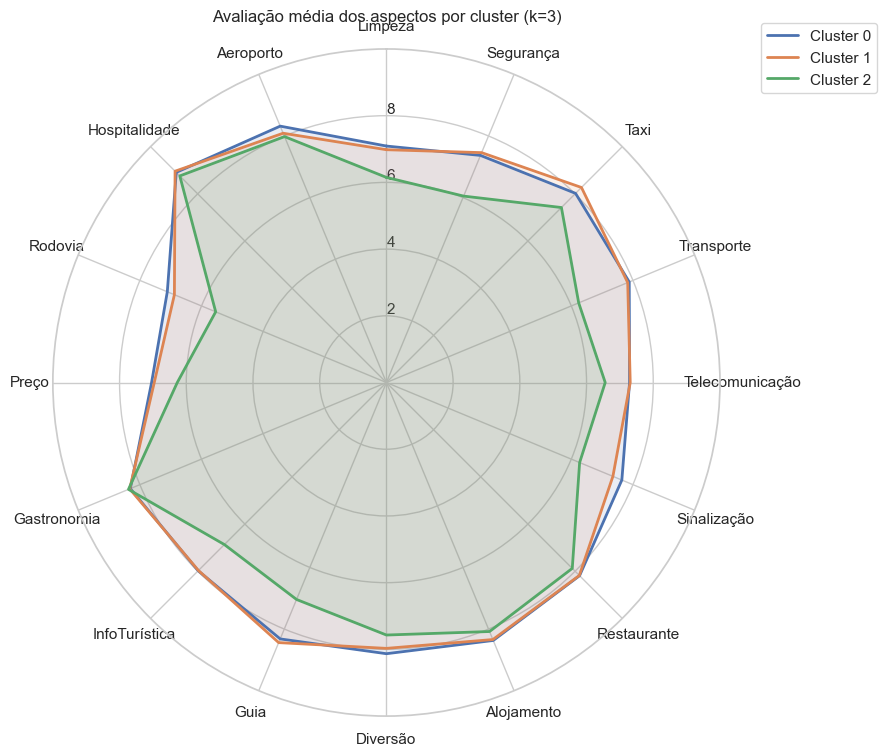

In [9]:
"""
Bloco 8 — Tabela 2 (percepções por cluster) + gráfico radar
- Converte 'ava*' para numérico (trata 'NS/NR', vírgula decimal etc.).
- Calcula médias por cluster, formata para o artigo e exporta CSV/XLSX.
- Plota um radar único com os três clusters e salva em figures/radar_k3_todos.png.
Pré-requisitos: df_modelo (com 'cluster_k3'); utilitários do Bloco 0.
"""

# 8.1) Lista canônica (ordem desejada no artigo)
aspectos_ordenados = [
    "avaLimpeza","avaSeguranca","avaTaxi","avaTransporte","avaTelecomunicacao",
    "avaSinalizacao","avaRestaurante","avaAlojamento","avaDiversao","avaGuia",
    "avaInfoTuristica","avaGastronomia","avaPreco","avaRodovia",
    "avaHospitalidade","avaAeroporto"
]

# mantém só as que existem no df
ava_cols = [c for c in aspectos_ordenados if c in df_modelo.columns]
if not ava_cols:
    raise ValueError("Nenhuma coluna 'ava*' encontrada no df_modelo.")

# 8.2) Conversão robusta para numérico
def _to_num(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    # trata marcadores textuais
    s = s.replace({
        "NS/NR": np.nan, "NS - NR": np.nan, "NA": np.nan,
        "": np.nan, "nan": np.nan
    })
    # vírgula decimal -> ponto
    s = s.str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

df_ava = df_modelo[ava_cols].apply(_to_num)

# descarta colunas que ficaram 100% NaN após coerção
validas = [c for c in ava_cols if df_ava[c].notna().any()]
descartadas = [c for c in ava_cols if c not in validas]
if descartadas:
    print("Descartadas (100% NaN após coerção):", descartadas)
if not validas:
    raise ValueError("Após a coerção, nenhuma 'ava*' manteve valores numéricos.")

# 8.3) Médias por cluster (ordem 0–1–2)
medias = (
    df_ava.groupby(df_modelo["cluster_k3"])[validas]
          .mean()
          .reindex(CLUSTER_ORDEM)
          .round(2)
)

# 8.4) Rótulos legíveis
rotulos = {
    "avaLimpeza":"Limpeza","avaSeguranca":"Segurança","avaTaxi":"Taxi","avaTransporte":"Transporte",
    "avaTelecomunicacao":"Telecomunicação","avaSinalizacao":"Sinalização","avaRestaurante":"Restaurante",
    "avaAlojamento":"Alojamento","avaDiversao":"Diversão","avaGuia":"Guia","avaInfoTuristica":"InfoTurística",
    "avaGastronomia":"Gastronomia","avaPreco":"Preço","avaRodovia":"Rodovia",
    "avaHospitalidade":"Hospitalidade","avaAeroporto":"Aeroporto"
}
rotulos_validos = {c: rotulos.get(c, c) for c in validas}
medias = medias.rename(columns=rotulos_validos)

# 8.5) Formato do artigo (Aspecto nas linhas; clusters nas colunas)
tabela2 = medias.T.copy()
tabela2.columns = [f"Cluster {c}" for c in tabela2.columns]

# 8.6) Exporta
salvar_csv_ptbr(
    tabela2.reset_index().rename(columns={"index":"Aspecto avaliado"}),
    "tables/Tabela_2_percepcoes_por_cluster.csv"
)
salvar_excel(
    tabela2.reset_index().rename(columns={"index":"Aspecto avaliado"}),
    "tables/Tabela_2_percepcoes_por_cluster.xlsx",
    nome_aba="Tabela 2"
)

display(tabela2)

# 8.7) Gráfico Radar (um polígono por cluster)
labels = tabela2.index.tolist()
N = len(labels)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # fecha o círculo

plt.figure(figsize=(9, 9))
ax = plt.subplot(111, polar=True)

# grade e limites
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.set_ylim(0, 10)
ax.set_yticks([2,4,6,8])
ax.set_yticklabels(["2","4","6","8"])

# rótulos dos eixos
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# plota cada cluster com paleta fixa
for k in CLUSTER_ORDEM:
    linha = tabela2[f"Cluster {k}"].tolist()
    linha += linha[:1]
    ax.plot(angles, linha, linewidth=2, label=f"Cluster {k}", color=CLUSTER_PALETA[k])
    ax.fill(angles, linha, alpha=0.12, color=CLUSTER_PALETA[k])

ax.set_title("Avaliação média dos aspectos por cluster (k=3)", pad=20)
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.05))
plt.tight_layout()
plt.savefig("figures/radar_k3_todos.png", dpi=150, bbox_inches="tight")
plt.show()


In [ ]:
"""
Bloco 9 — Pós-testes numéricos por pares (Mann–Whitney + Holm) e tamanho de efeito (Cliff's delta) para o Apêndice
Pré-requisitos: df_modelo com 'cluster_k3', 'logGasto','logPernoite','idade_mediana'
Saídas: tables/Tabela_B2_posthoc_numericas.csv
"""

from itertools import combinations
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

def cliffs_delta(x, y):
    """Tamanho de efeito para duas amostras independentes (ordinais/contínuas)."""
    x = np.asarray(x); y = np.asarray(y)
    # amostras menores para acelerar se muito grandes (sem perder sinal)
    nmax = 8000
    if len(x) > nmax: x = np.random.default_rng(42).choice(x, nmax, replace=False)
    if len(y) > nmax: y = np.random.default_rng(42).choice(y, nmax, replace=False)
    gt = np.sum(x[:, None] > y[None, :])
    lt = np.sum(x[:, None] < y[None, :])
    d  = (gt - lt) / (x.size * y.size)
    return d

def holm_adjust(pvals):
    """Ajuste de Holm para uma lista de p-values na mesma ordem de entrada."""
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty(m)
    running = 0.0
    for rank, idx in enumerate(order, start=1):
        adj[idx] = min(1.0, (m - rank + 1) * pvals[idx])
    # monotonicidade crescente
    for i in np.argsort(order):
        if i > 0:
            adj[order[i]] = max(adj[order[i]], adj[order[i-1]])
    return adj

variaveis = ["logGasto","logPernoite","idade_mediana"]
pares = list(combinations([0,1,2], 2))

linhas = []
for var in variaveis:
    grupos = {k: df_modelo.loc[df_modelo["cluster_k3"]==k, var].dropna().values for k in [0,1,2]}
    # p-values brutos
    p_raw = []
    stats = []
    deltas = []
    for (a,b) in pares:
        st = mannwhitneyu(grupos[a], grupos[b], alternative="two-sided")
        p_raw.append(st.pvalue)
        stats.append(st.statistic)
        deltas.append(cliffs_delta(grupos[a], grupos[b]))
    p_adj = holm_adjust(np.array(p_raw))
    # monta linhas
    for (a,b), stat, p0, pH, d in zip(pares, stats, p_raw, p_adj, deltas):
        linhas.append({
            "variavel": var,
            "comparacao": f"{a}×{b}",
            "estatistica": float(stat),
            "p_bruto": p0,
            "p_ajustado_holm": pH,
            "cliffs_delta": d
        })

posthoc_num = pd.DataFrame(linhas)
# formatação pt-BR para relatório
posthoc_fmt = posthoc_num.copy()
posthoc_fmt["estatistica"] = posthoc_fmt["estatistica"].round(2)
posthoc_fmt["p_bruto"] = posthoc_fmt["p_bruto"].apply(lambda x: "<0,001" if x<1e-3 else f"{x:.3f}".replace(".",","))
posthoc_fmt["p_ajustado_holm"] = posthoc_fmt["p_ajustado_holm"].apply(lambda x: "<0,001" if x<1e-3 else f"{x:.3f}".replace(".",","))
posthoc_fmt["cliffs_delta"] = posthoc_fmt["cliffs_delta"].round(3).astype(str).str.replace(".", ",")

posthoc_fmt.to_csv("tables/posthoc_numericas.csv", sep=";", decimal=",", index=False, encoding="utf-8-sig")
display(posthoc_fmt.head(9))


,variavel,comparacao,estatistica,p_bruto,p_ajustado_holm,cliffs_delta
0,logGasto,0×1,64567060.5,"<0,001","<0,001","-0,099"
1,logGasto,0×2,31395147.5,"<0,001","<0,001","-0,537"
2,logGasto,1×2,33494851.0,"<0,001","<0,001","-0,436"
3,logPernoite,0×1,71187431.0,"0,238","0,238","-0,007"
4,logPernoite,0×2,4927288.0,"<0,001","<0,001","-0,927"
5,logPernoite,1×2,5408563.0,"<0,001","<0,001","-0,91"
6,idade_mediana,0×1,268352.0,"<0,001","<0,001","-0,996"
7,idade_mediana,0×2,42360942.5,"<0,001","<0,001","-0,383"
8,idade_mediana,1×2,98820292.5,"<0,001","<0,001","0,661"
